<a href="https://colab.research.google.com/github/sayak395/2025-Quantinuum-DechoherenceGang/blob/main/Driven_Jaynes_Cummings_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from qutip import (basis, destroy, mesolve, qeye, tensor, create, sigmaz, sigmam, sigmap, fock, Qobj, fidelity, Options)
from scipy.signal import find_peaks

# System parameters
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi # cavity-atom coupling

# Hilbert space dimension for the cavity
n_cavity = 10

sigma_z_np = np.array([[1 , 0],
                   [0, -1]])
sigma_z_alt = Qobj(sigma_z_np)

sigma_plus_np = np.array([[0, 1],
                   [0, 0]])

sigma_plus_alt = Qobj(sigma_plus_np)

sigma_minus_np = np.transpose(sigma_plus_np)

sigma_minus_alt = Qobj(sigma_minus_np)

def create_a(n):

    matrix = np.zeros((n, n))

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if j == i - 1:
                matrix[i , j] = np.sqrt(i)

    return Qobj(np.transpose(matrix))


###########################
# Define the Operators
###########################

sigma_minus = tensor(qeye(n_cavity), sigma_minus_alt) # atomic lowering operator
sigma_plus =  tensor(qeye(n_cavity), sigma_plus_alt)  # atomic raising operator
sigma_z = tensor(qeye(n_cavity), sigma_z_alt)     # atomic z operator
a = tensor(create_a(n_cavity), qeye(2))   # cavity annihilation operator
spin_down = fock(2, 1)
spin_up = fock(2, 0)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 78.3 MB/s eta 0:00:00


In [3]:
f = 1.0 * 2 * np.pi # laser-atom coupling
w0 = 1.0 * 2 * np.pi # laser driving frequency

In [4]:
delta_c = wc - w0
delta_a = wa - w0
times = np.arange(0, 50, 1e-5)
tau = wc * times

psi0 = tensor(fock(n_cavity, 3), spin_down)

In [5]:
H_driven_RWA = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + g * (sigma_plus * a + sigma_minus * a.dag()) + 0.5 * f * (sigma_plus + sigma_minus)

H_driven_RWA = H_driven_RWA/wc

In [28]:
#result = mesolve(H_driven_RWA, psi0, tau, c_ops = [], e_ops = [a.dag() * a, sigma_plus * sigma_minus])

In [29]:
# n_c = result.expect[0]
# n_a = result.expect[1]

# plt.figure()
# plt.plot(tau, n_c, label = 'Cavity')
# plt.plot(tau, n_a, label = 'Atom Excited State')
# plt.grid(True)
# plt.xlabel('Time (arb. units)')
# plt.ylabel('Fock state')
# plt.legend(loc='best')
# plt.show()

In [6]:
times = np.arange(0, 120, 1e-4)
#tau = wc * times

In [7]:
#############
# Start and end state


psi = tensor(fock(n_cavity, 0), spin_down)

psi_den = psi * psi.dag()

target_state = tensor(fock(n_cavity, 1), spin_down)

target_den = target_state * target_state.dag()

In [8]:
!pip install scikit-optimize

from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence
from skopt.utils import use_named_args


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [33]:
# # Search space for Bayesian Optimization
# space  = [Real(0.0, 25.0 * 2 * np.pi, name='f'),
#           Real(0, 100, name='t')]

# g = 0.05

# # General objective function that accepts named arguments
# def objective_general(f, t):
#     wc = wa
#     w0 = wc
#     delta_c = wc - w0
#     delta_a = wa - w0
#     tau = wc * t
#     H = (delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + g * (sigma_plus * a + sigma_minus * a.dag()) + 0.5 * f * (sigma_minus + sigma_plus))
#     H /= wc
#     result = mesolve(H, psi_den, [0, tau], c_ops=[], e_ops=[], options=Options(store_final_state=True, nsteps = 100000000000, atol = 1e-7, rtol = 1e-7))
#     final_rho = result.states[-1]
#     fid = fidelity(target_den, final_rho)
#     return -fid  # return negative fidelity for minimization

# def objective(x):
#     return objective_general(x[0], x[1])

# # Perform Bayesian Optimization
# res = gp_minimize(objective, space, n_calls=100, random_state=42, verbose=True, acq_func='EI')

# # Best parameters found
# print(f"Optimal f: {res.x[0]/(2 * np.pi):.2f}, Optimal t: {res.x[1]:.2f} s")

In [34]:
#plot_convergence(res)
#plt.show()

In [9]:
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

#fig = plot_objective(res, dimensions=['f', 't'])
#plt.show()

In [36]:
#fig = plot_evaluations(res, dimensions=['f', 't'])
#plt.show()

# ** Implenting pulse powered f(t)**

In [37]:
def f_t(t, args):
    """ Time-dependent driving amplitude.
        args contains 'on_time' when the pulse turns off.
    """
    on_time = args['on_time']
    f_max = args['f_max']/wc
    return f_max if t < on_time else 0


In [10]:
wc = wa = 1.0  # Example values
w0 = wc # resonance driving
delta_c = (wc - w0)/wc
delta_a = (wa - w0)/wc

def objective_general(f_max, on_time, extra_time):

    end_time = on_time + extra_time
    tau = wc * end_time  # Total time and steps for simulation

    # Time-dependent driving term
    H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t, args: f_t(t, args)]
    H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + (g/wc) * (sigma_plus * a + sigma_minus * a.dag())
    H = [H_static, H_drive]

    result = mesolve(H, psi_den, [0, tau], c_ops=[], e_ops=[], options={'nsteps': 1e9, 'atol': 1e-7, 'rtol': 1e-7}, args={'on_time': on_time, 'f_max': f_max})
    final_rho = result.states[-1]
    fid = fidelity(target_den, final_rho)
    return -fid  # Negative for minimisation

In [39]:
def objective(x):
    return objective_general(x[0], x[1], x[2])

# Define the parameter space
space = [
    Real(0.0, g, name='f_max'),  # Max amplitude of the pulse
    Real(0, 100, name='on_time'), # Time at which the pulse turns off
    Real(1, 100, name='extra_time') # Total simulation time
]

# Perform Bayesian Optimization
res = gp_minimize(objective, space, n_calls=100, random_state=42, verbose=True, acq_func='EI')

# Print the best parameters found
print(f"Optimal f_max: {res.x[0]/(2 * np.pi):.2f} rad/s, Optimal on_time: {res.x[1]:.2f} s, Optimal end_time {res.x[2] + res.x[1]:.2f} s")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2186
Function value obtained: -0.1644
Current minimum: -0.1644
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1539
Function value obtained: -0.2967
Current minimum: -0.2967
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4009
Function value obtained: -0.1983
Current minimum: -0.2967
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1108
Function value obtained: -0.4746
Current minimum: -0.4746
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1532
Function value obtained: -0.0000
Current minimum: -0.4746
Iteration No: 6 started. 

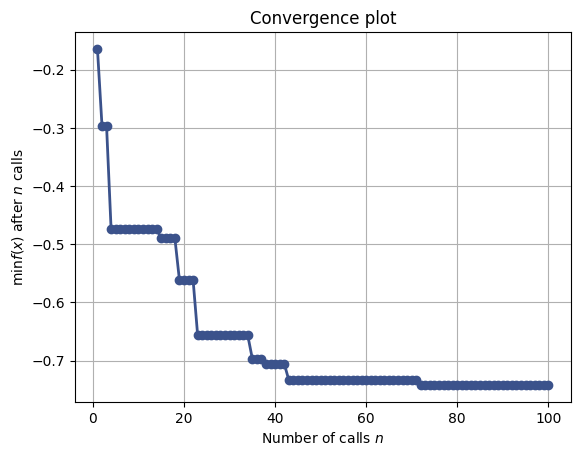

In [40]:
plot_convergence(res)
plt.show()

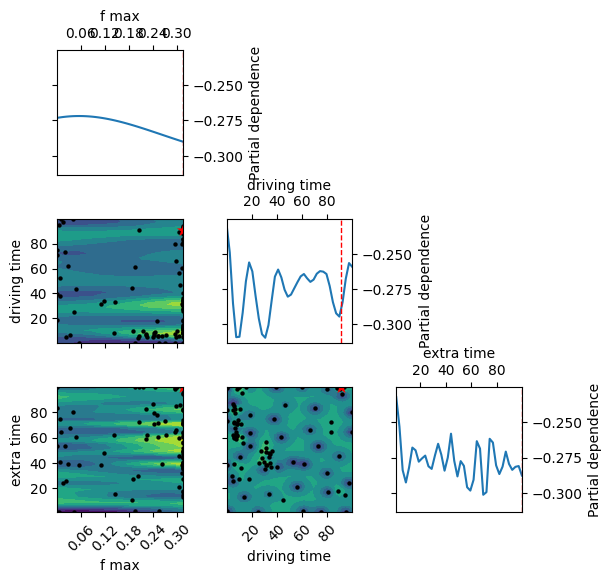

In [41]:
fig = plot_objective(res, dimensions=['f max', 'driving time', 'extra time'])
plt.show()

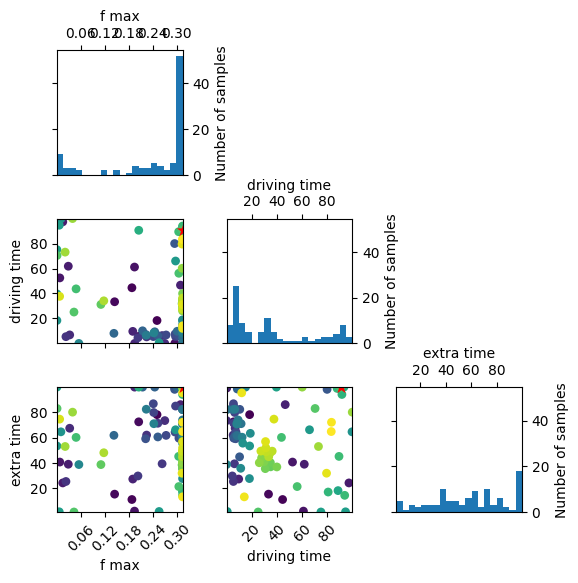

In [42]:
fig = plot_evaluations(res, dimensions=['f max', 'driving time', 'extra time'])
plt.show()

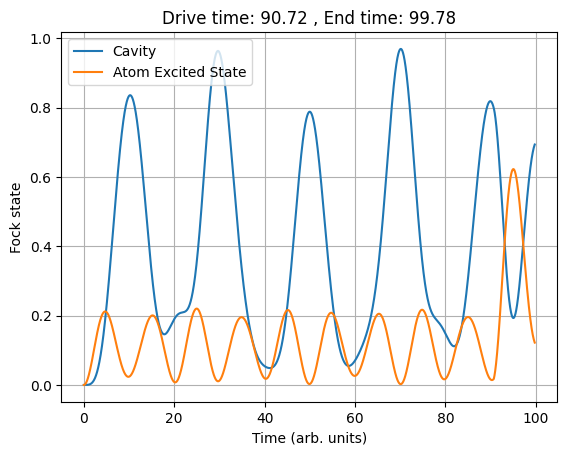

In [43]:
# Plotting the results

psi = tensor(fock(n_cavity, 0), spin_down)

# Time-dependent driving term
H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t, args: f_t(t, args)]
H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + g * (sigma_plus * a + sigma_minus * a.dag())
H = [H_static, H_drive]

t = np.arange(0, res.x[2], 1e-4)
output = mesolve(H, psi, t, c_ops=[], e_ops=[a.dag() * a, sigma_plus * sigma_minus], args={'on_time': res.x[1], 'f_max': res.x[0]})

n_c = output.expect[0]
n_a = output.expect[1]

plt.figure()
plt.title(f'Drive time: {res.x[1]:.2f} , End time: {res.x[2]:.2f}')
plt.plot(t, n_c, label = 'Cavity')
plt.plot(t, n_a, label = 'Atom Excited State')
plt.grid(True)
plt.xlabel('Time (arb. units)')
plt.ylabel('Fock state')
plt.legend(loc='best')
plt.show()


# Adding dissipation terms

In [44]:
kappa = 0.01  # Photon loss rate
gamma = 0.01  # Spontaneous emission rate

c_ops = [
        np.sqrt(kappa) * a,          # photon loss
        #np.sqrt(gamma) * sigma_minus # Spontaneous emission
    ]


In [45]:
def objective_general(f_max, on_time, extra_time):
    wc = wa = 1.0  # Example values
    w0 = wc
    delta_c = (wc - w0)/wc
    delta_a = (wa - w0)/wc

    end_time = on_time + extra_time
    tau = wc * end_time  # Total time and steps for simulation

    # Time-dependent driving term
    H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t, args: f_t(t, args)]
    H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + (g/wc) * (sigma_plus * a + sigma_minus * a.dag())
    H = [H_static, H_drive]

    result = mesolve(H, psi_den, [0, tau], c_ops=[c_ops], e_ops=[], options={'nsteps': 1e9, 'atol': 1e-7, 'rtol': 1e-7}, args={'on_time': on_time, 'f_max': f_max})
    final_rho = result.states[-1]
    fid = fidelity(target_den, final_rho)
    return -fid  # Negative for minimization

In [46]:
def objective(x):
    return objective_general(x[0], x[1], x[2])

# Define the parameter space
space = [
    Real(0.0, 25.0 * 2 * np.pi, name='f_max'),  # Max amplitude of the pulse
    Real(0, 100, name='on_time'), # Time at which the pulse turns off
    Real(100, 200, name='end_time') # Total simulation time
]

# Perform Bayesian Optimization
res_loss = gp_minimize(objective, space, n_calls=100, random_state=42, verbose=True, acq_func='EI')

# Print the best parameters found
print(f"Optimal f max: {res_loss.x[0]/(2 * np.pi):.2f} rad/s, Optimal drive time: {res_loss.x[1]:.2f} s, Optimal end time {res_loss.x[2] + res_loss.x[1]:.2f} s")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.7329
Function value obtained: -0.4361
Current minimum: -0.4361
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.8196
Function value obtained: -0.4026
Current minimum: -0.4361
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.8680
Function value obtained: -0.4343
Current minimum: -0.4361
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.3731
Function value obtained: -0.4812
Current minimum: -0.4812
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3193
Function value obtained: -0.0734
Current minimum: -0.4812
Iteration No: 6 started. 

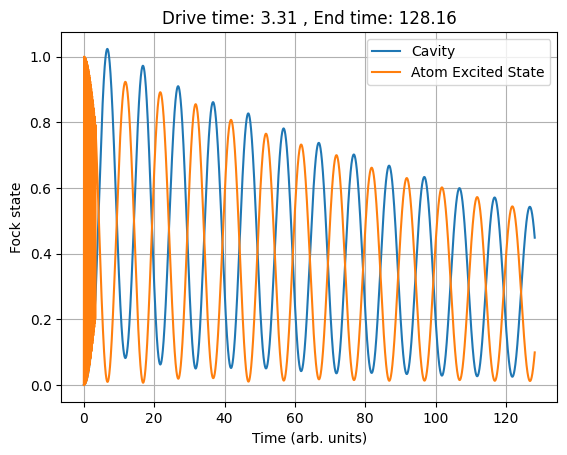

In [47]:
# Plotting the results

psi = tensor(fock(n_cavity, 0), spin_down)

# Time-dependent driving term
H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t, args: f_t(t, args)]
H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + (g/wc) * (sigma_plus * a + sigma_minus * a.dag())
H = [H_static, H_drive]

t = np.arange(0, res_loss.x[2] + res_loss.x[1], 1e-4)
output = mesolve(H, psi, t, c_ops=[c_ops], e_ops=[a.dag() * a, sigma_plus * sigma_minus], args={'on_time': res_loss.x[1], 'f_max': res_loss.x[0]})

n_c = output.expect[0]
n_a = output.expect[1]

plt.figure()
plt.title(f'Drive time: {res_loss.x[1]:.2f} , End time: {res_loss.x[2] + res_loss.x[1]:.2f}')
plt.plot(t, n_c, label = 'Cavity')
plt.plot(t, n_a, label = 'Atom Excited State')
plt.grid(True)
plt.xlabel('Time (arb. units)')
plt.ylabel('Fock state')
plt.legend(loc='best')
plt.show()


# **Implementing cosine like driving terms**

In [14]:
def f_t(t, args):
    """ Time-dependent driving amplitude with multiple cosine terms.
        Each cosine term has its own amplitude and frequency.
        All terms turn off the driving after `on_time`.
    """
    #if t > args['on_time']:
        #return 0  # Turn off all driving after the specified time

    n_terms = len(args['amplitudes'])  # Assuming the same number of frequencies and amplitudes
    drive_amplitude = 0

    for n in range(n_terms):
        amplitude = args['amplitudes'][n]
        frequency = args['frequencies'][n]  # Frequency for each term is now parameterized
        drive_amplitude += amplitude * np.cos(frequency * t)

    return drive_amplitude

In [37]:
from skopt.space import Real
from skopt import gp_minimize

N_TERMS = 1  # Adjust based on how many terms you need

def objective_general(amplitudes, frequencies, sim_time):
    tau = wc * sim_time # Time array for simulation

    # Prepare args dictionary to pass all necessary parameters
    args = {'sim_time': sim_time, 'amplitudes': amplitudes, 'frequencies': frequencies}

    # Define the Hamiltonian components
    H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + (g/wc) * (sigma_plus * a + sigma_minus * a.dag())
    H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t: f_t(t, args)]  # Ensure lambda uses args directly

    # Hamiltonian setup
    H = [H_static, H_drive]

    # Simulation with mesolve
    result = mesolve(H, psi_den, [0, tau], c_ops=[], e_ops=[], options={'nsteps': 1e9, 'atol': 1e-7, 'rtol': 1e-7})
    final_rho = result.states[-1]
    fid = fidelity(final_rho, target_den)
    return -fid  # Minimize negative fidelity

def objective(x):
    n_terms = N_TERMS
    amplitudes = x[:n_terms]
    frequencies = x[n_terms:2*n_terms]
    sim_time = x[2*n_terms]
    return objective_general(amplitudes, frequencies, sim_time)


# Define the parameter space for Bayesian Optimization
space = [Real(0.0, g, name='amplitude') for _ in range(N_TERMS)] + \
        [Real(0.0, g, name='frequency') for _ in range(N_TERMS)] + \
        [Real(0, 1000, name='sim_time')]

# Perform Bayesian Optimisation
res = gp_minimize(objective, space, n_calls=100, random_state=42, verbose=True, acq_func='EI')
from skopt.space import Real
from skopt import gp_minimize

N_TERMS = 1  # Adjust based on how many terms you need

def objective_general(amplitudes, frequencies, sim_time):
    tau = wc * sim_time # Time array for simulation

    # Prepare args dictionary to pass all necessary parameters
    args = {'sim_time': sim_time, 'amplitudes': amplitudes, 'frequencies': frequencies}

    # Define the Hamiltonian components
    H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + (g/wc) * (sigma_plus * a + sigma_minus * a.dag())
    H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t: f_t(t, args)]  # Ensure lambda uses args directly

    # Hamiltonian setup
    H = [H_static, H_drive]

    # Simulation with mesolve
    result = mesolve(H, psi_den, [0, tau], c_ops=[], e_ops=[], options={'nsteps': 1e9, 'atol': 1e-7, 'rtol': 1e-7})
    final_rho = result.states[-1]
    fid = fidelity(final_rho, target_den)
    return -fid  # Minimize negative fidelity

def objective(x):
    n_terms = N_TERMS
    amplitudes = x[:n_terms]
    frequencies = x[n_terms:2*n_terms]
    sim_time = x[2*n_terms]
    return objective_general(amplitudes, frequencies, sim_time)


# Define the parameter space for Bayesian Optimization
space = [Real(0.0, g, name='amplitude') for _ in range(N_TERMS)] + \
        [Real(0.0, g, name='frequency') for _ in range(N_TERMS)] + \
        [Real(0, 1000, name='sim_time')]

# Perform Bayesian Optimisation
res = gp_minimize(objective, space, n_calls=100, random_state=42, verbose=True, acq_func='EI')

# Print the best parameters found
print(f"Optimal amplitudes: {res.x[:N_TERMS]}, Optimal frequencies: {res.x[N_TERMS:2*N_TERMS]}, Optimal simulation time: {res.x[2*N_TERMS]}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4364
Function value obtained: -0.0164
Current minimum: -0.0164
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2587
Function value obtained: -0.1722
Current minimum: -0.1722
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2427
Function value obtained: -0.4052
Current minimum: -0.4052
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.3212
Function value obtained: -0.3060
Current minimum: -0.4052
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.6564
Function value obtained: -0.0566
Current minimum: -0.4052
Iteration No: 6 started. 

In [ ]:
#Extract parameters from Bayesian optimization results
amplitudes = res.x[:N_TERMS]  # Assuming the last two parameters are on_time and
frequencies = res.x[N_TERMS:2*N_TERMS]
sim_time = res.x[2*N_TERMS]


time_array = np.linspace(0, wc * sim_time, 1000)

# Create args dictionary
args = {
    'amplitudes': amplitudes,
    'frequencies': frequencies,
    'sim_time': sim_time
}

# Calculate the driving signal using the correct dictionary format for args
driving_signal = [f_t(t, args) for t in time_array]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_array, driving_signal, label="Driving Amplitude $f(t)$")
#plt.axvline(on_time, color='red', linestyle='--', label='On-time Cutoff')
plt.xlabel("Time (arb units.)")
plt.ylabel("Amplitude")
plt.title("Time-Dependent Driving Function $f(t)$")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Plotting the results

psi = tensor(fock(n_cavity, 0), spin_down)

# Time-dependent driving term
H_drive = [0.5 * (sigma_plus + sigma_minus), lambda t, args: f_t(t, args)]
H_static = delta_c * a.dag() * a + 0.5 * delta_a * sigma_z + (g/wc) * (sigma_plus * a + sigma_minus * a.dag())
H = [H_static, H_drive]

t = np.linspace(0, sim_time, 10000)
output = mesolve(H, psi, t, c_ops=[], e_ops=[a.dag() * a, sigma_plus * sigma_minus], args={'amplitudes': res.x[:N_TERMS], 'frequencies': res.x[N_TERMS:2*N_TERMS]})

n_c = output.expect[0]
n_a = output.expect[1]

plt.figure()
#plt.title(f'Drive time: {res_loss.x[1]:.2f} , End time: {res_loss.x[2] + res_loss.x[1]:.2f}')
plt.plot(t, n_c, label = 'Cavity')
plt.plot(t, n_a, label = 'Atom Excited State')
plt.grid(True)
plt.xlabel('Time (arb. units)')
plt.ylabel('Fock state')
plt.legend(loc='best')
plt.show()